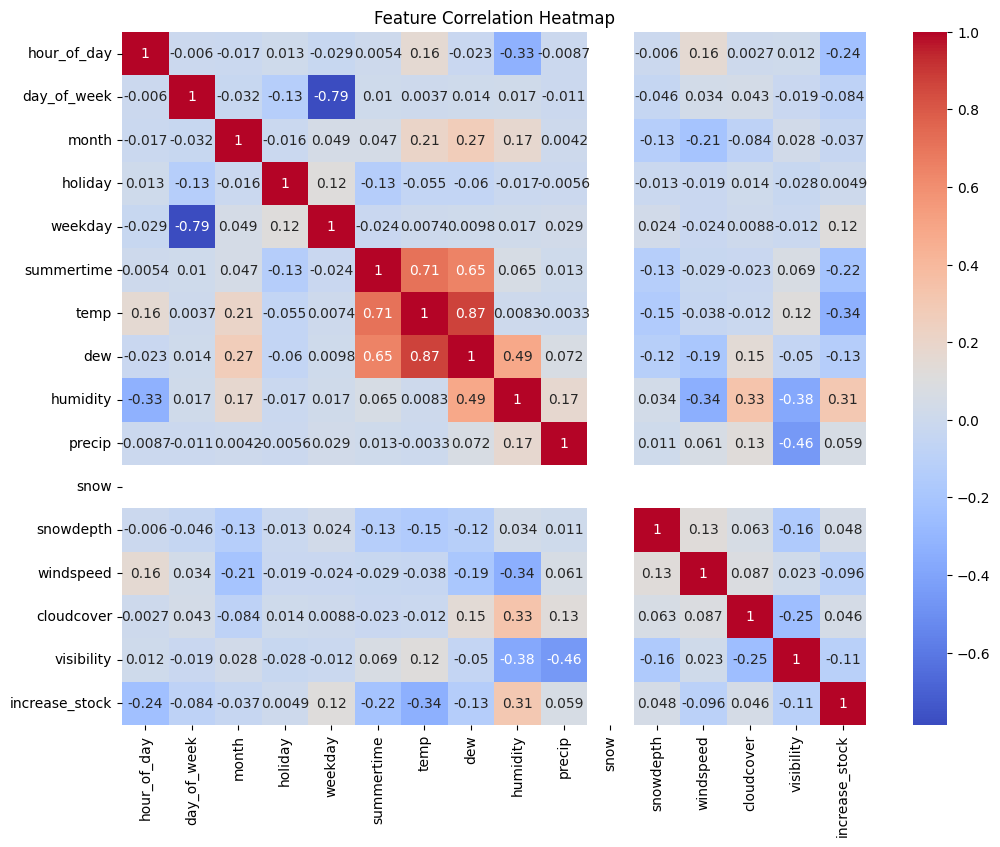

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Load Data
df = pd.read_csv("training_data_fall2024.csv")

# Convert string values to integers
df["increase_stock"] = (df["increase_stock"] == "low_bike_demand").astype(int)

# Visualize the correlation matrix to identify highly correlated features
correlation_matrix = df.corr() 
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Feature Correlation Heatmap') 
plt.show()


In [76]:
# Remove features with very low or no correlation to the target
# Remove dew due to high correlation with temp
df = df.drop(columns=['holiday','dew','snow'])

# Split the dataset into 80% training and 20% test sets
train, test = np.split(df.sample(frac=1, random_state=42), [int(0.8 * len(df))])

In [77]:
# Function to scale the dataset without oversampling
def scale_dataset(dataframe):
    x = dataframe[dataframe.columns[:-1]].values  # Extract feature columns
    y = dataframe[dataframe.columns[-1]].values  # Extract target column
    scaler = StandardScaler()  # Initialize the scaler
    X = scaler.fit_transform(x)  # Scale the features
    return X, y

In [78]:
# Scale the training and test datasets
X_train, y_train = scale_dataset(train)
X_test, y_test = scale_dataset(test)

# Print the class balance in the training data
print(f"Class 1 count in training: {sum(y_train == 1)}")
print(f"Class 0 count in training: {sum(y_train == 0)}")

Class 1 count in training: 1058
Class 0 count in training: 222


The optimal number of neighbors is 22


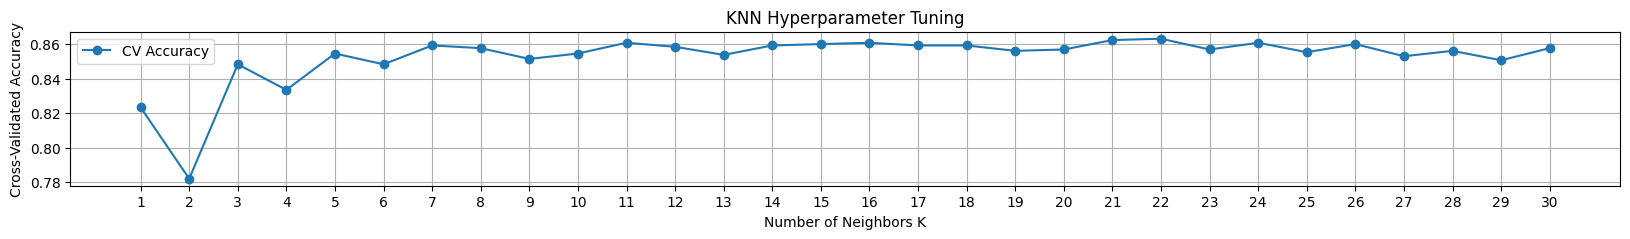

In [80]:
X_test, y_test = scale_dataset(test)

# Find the optimal value of K using cross-validation
k_range = range(1, 31)  # Testing K values from 1 to 30
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold CV
    cv_scores.append(scores.mean())

# Find the K with the highest accuracy
optimal_k = k_range[np.argmax(cv_scores)]
print(f"The optimal number of neighbors is {optimal_k}")

# Plot cross-validated accuracy vs. K
plt.figure(figsize=(20, 2))
plt.plot(k_range, cv_scores, marker='o', label='CV Accuracy')
plt.xlabel("Number of Neighbors K")
plt.ylabel("Cross-Validated Accuracy")
plt.title("KNN Hyperparameter Tuning")
plt.xticks(k_range)
plt.grid()
plt.legend()
plt.show()


In [81]:
# Train the KNN model with the optimal K
knn_model = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')
knn_model.fit(X_train, y_train)

# Predict labels for the test data
y_pred = knn_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.38      0.50        66
           1       0.86      0.96      0.91       254

    accuracy                           0.84       320
   macro avg       0.79      0.67      0.70       320
weighted avg       0.83      0.84      0.82       320



In [82]:
# Get the index of the maximum value
best_index = cv_scores.index(max(cv_scores)) 
print(f"The best value of k is {optimal_k} with an accuracy of {cv_scores[best_index]:.4f}")

The best value of k is 22 with an accuracy of 0.8633


In [83]:
# Handiling Oversampling to balance the data
def scale_dataset(dataframe, oversample=False):
    # Check if the input is a NumPy array
    if isinstance(dataframe, np.ndarray):
        dataframe = pd.DataFrame(dataframe)
    
    x = dataframe[dataframe.columns[:-1]].values  # Extract feature columns
    y = dataframe[dataframe.columns[-1]].values  # Extract target column
    scaler = StandardScaler()     # Initialize the scaler to normalize the features
    X = scaler.fit_transform(x)   # Scale the features to have mean 0 and standard deviation 1

    # If oversampling is true, balance the data by increasing the minority class
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)
        
    # Combine the scaled features and target into one dataset
    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

# Training the data for balanced data 
train, X_train, y_train = scale_dataset(train, oversample=True)

# Print the number of samples for each class in the training data
print("Class 1 count after oversampling:",sum(y_train ==1))
print("Class 0 count after oversampling:",sum(y_train==0))

Class 1 count after oversampling: 1058
Class 0 count after oversampling: 1058


The optimal number of neighbors is 1


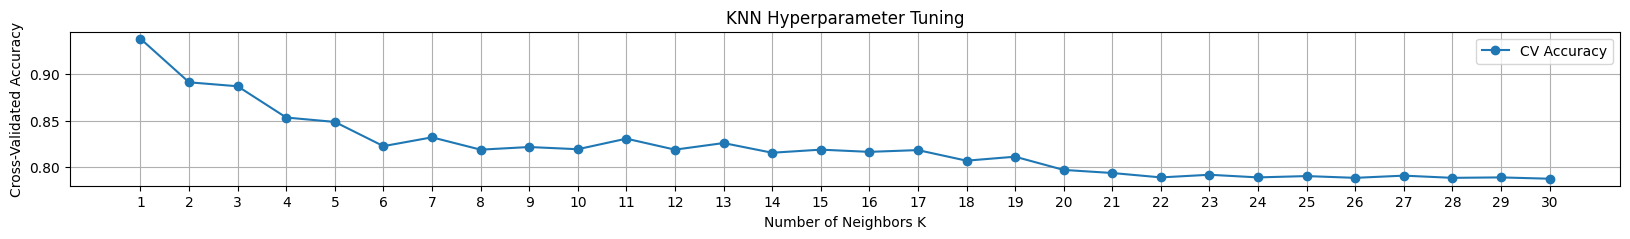

In [84]:
# Balance the training data using oversampling and scale
train, X_train, y_train = scale_dataset(train, oversample=True)
test, X_test, y_test = scale_dataset(test, oversample=False)

# Find the optimal value of K using cross-validation
k_range = range(1, 31)  # Testing K values from 1 to 30
cv_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold CV
    cv_scores.append(scores.mean())

# Find the K with the highest accuracy
optimal_k = k_range[np.argmax(cv_scores)]
print(f"The optimal number of neighbors is {optimal_k}")

# Plot cross-validated accuracy vs. K
plt.figure(figsize=(20, 2))
plt.plot(k_range, cv_scores, marker='o', label='CV Accuracy')
plt.xlabel("Number of Neighbors K")
plt.ylabel("Cross-Validated Accuracy")
plt.title("KNN Hyperparameter Tuning")
plt.xticks(k_range)
plt.grid()
plt.legend()
plt.show()

In [85]:
# Train the KNN model with the optimal K
# Weight by the inverse of distance (closer neighbors contribute more)
knn_model = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')

# giving our X and y training data
knn_model.fit(X_train, y_train)
# Predict labels for the test data
y_pred = knn_model.predict(X_test)

# Predict labels for the test data and print the classification report
y_pred = knn_model.predict(X_test)

# Classification report for the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.58      0.51        66
           1       0.88      0.82      0.85       254

    accuracy                           0.77       320
   macro avg       0.67      0.70      0.68       320
weighted avg       0.79      0.77      0.78       320



In [86]:
# Get the index of the maximum value
best_index = cv_scores.index(max(cv_scores))  
print(f"The best value of k is {optimal_k} with an accuracy of {cv_scores[best_index]:.4f}")

The best value of k is 1 with an accuracy of 0.9381
